<a href="https://colab.research.google.com/github/andBabaev/ds_school_2020/blob/master/task%203/Babaev_Andrei_neuralnetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris , make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Loss functions and score

In [0]:
def cross_entropy(y_true, probas):
    return (-np.sum(y_true*np.log(probas), axis=1)).mean()

def rmse(y_true, y_pred):
    return np.sqrt((np.power(y_true - y_pred, 2).mean()))

def accuracy(y_true, y_pred):
    return (y_true==y_pred).mean()

# Activation functions

In [0]:
class Sigmoid:
    """Sigmoid activation function"""
    def __init__(self):
        pass

    def compute_y(self, x):
        '''Return sigmoid(x)

        Argument
            x - scalar or numpy array'''
        return 1/(1+np.exp(-x))

    def compute_derivative(self, sig_value):
        '''Return derivative of sigmoid
        
        Argument
            sig_value - sigmoid value that can be calculated using the function compute_y(x); scalar or numpy array'''
        return sig_value * (1 - sig_value)

    def compute_delta_last(self, y_true, y_pred):
        '''Return deltas for last layer of neural network which has sigmoid activation function
        
        Arguments
            y_true - Target variables; 2D numpy array
            y_pred - Predicted prababilities; 2D numpy array; shape like y_true'''
        return -(y_true/y_pred - (1-y_true)/(1-y_pred)) * self.compute_derivative(y_pred)

    def compute_delta_nonlast(self, delta, y_pred):
        '''Return deltas for non layer of neural network which has sigmoid activation function
        
        Arguments
            delta - the dot product of deltas and weights; 2D numpy array
            y_pred - Predicted prababilities; 2D numpy array; shape like y_true'''
        return delta * self.compute_derivative(y_pred)

    

class Softmax:
    '''Softmax activation function'''
    def __init__(self):
        pass
        
    def compute_y(self, x):
        '''Return softmax(x)

        Argument
            x - numpy array'''
        arg = x
        return np.exp(arg)/np.sum(np.exp(arg), axis=0)

    def compute_delta_last(self, y_true, y_pred):
        '''Return deltas for last layer of neural network which has softmax activation function
        
        Arguments
            y_true - Target variables; 2D numpy array
            y_pred - Predicted prababilities; 2D numpy array; shape like y_true'''
        return y_pred - y_true


# Class Layer

In [0]:
class Layer:
    '''
    Layer of neural network 

    Arguments:
        n_neurons - number of neurons; scalar
        f_activation - activation function for layer; 'softmax' or 'sigmoid'; default 'sigmoid'
        input_shape - if first layer input_shape is a scalar else it is None

    '''
    def __init__(self, n_neurons, f_activation='sigmoid', input_shape=None):
        self.n_neurons = n_neurons
        self.input_shape = input_shape
        self.previous_layer = None

        if f_activation=='sigmoid':
            self.f_activation = Sigmoid()
        elif f_activation == 'softmax':
            self.f_activation = Softmax()


# NeuralNetworkClassifier

In [0]:
class NeuralNetworkClassifier:
    def __init__(self, layers, random_state=7):
        '''Dense neural network for classification task
        
        Argument
            layers - list Layers'''

        self.random_state = random_state
        self.layers = layers
        for i, layer in enumerate(self.layers):
            if layer.input_shape is None:
                self.layers[i].previous_layer = self.layers[i-1]
            else:
                #add fake previous_layer for creation matrix of params of first layer
                self.layers[i].previous_layer = Layer(layer.input_shape)
    
    def init_net(self):
        '''Initialization of weights'''
        np.random.seed(self.random_state)
        for i, layer in enumerate(self.layers):
            self.layers[i].weights = np.random.normal(size=(self.layers[i].n_neurons, 
                                                            self.layers[i].previous_layer.n_neurons),)  
        np.random.seed(None)
    
    def predict(self, X):
        '''Return probabilities for objects X

        Argument
            X - 2D numpy array'''
        inputs = X.T
        for i in range(len(self.layers)):
            self.layers[i].outputs = self.layers[i].f_activation.compute_y(self.layers[i].weights.dot(inputs))
            inputs = self.layers[i].outputs
        return inputs.T

    def predict_classes(self, X):
        '''Return probabilities for objects X

        Argument
            X - 2D numpy array'''
        probas = self.predict(X)
        return np.argmax(probas, axis=1)

    def get_classes_by_probas(self, probas):
        return np.argmax(probas, axis=1)
                
    def backprop(self, x, y_true, y_pred):
        n_data = y_true.shape[0]
        self.layers[0].previous_layer.outputs = x.T
        #find delta_w for last layer
        self.layers[-1].deltas = self.layers[-1].f_activation.compute_delta_last(y_true, y_pred).T#
        self.layers[-1].delta_w = self.layers[-1].deltas.dot(self.layers[-1].previous_layer.outputs.T)/n_data

        for_next_delta = self.layers[-1].weights.T.dot(self.layers[-1].deltas)
        
        #find delta_w for other layers
        for i in range(len(self.layers)-2, -1, -1):
            self.layers[i].deltas = self.layers[i].f_activation.compute_delta_nonlast(for_next_delta, self.layers[i].outputs)
            self.layers[i].delta_w = self.layers[i].deltas.dot(self.layers[i].previous_layer.outputs.T)/n_data

            if i:
                for_next_delta = self.layers[i].weights.T.dot(self.layers[i].deltas)

        #update weights
        for i in range(len(self.layers)):
            self.layers[i].weights -= self.lr * self.layers[i].delta_w


    def dropout_mask(self, shape):
        '''Return dropout mask
            shape - target shape; 2D array'''
        return np.random.binomial(1, 1-self.dropout, size=shape) / 1-self.dropout

    def predict_with_dropout(self, X):
        '''Return probabilities for objects X. Uses dropout. Only for training phase
            X - 2D numpy array'''
        m = self.dropout_mask(X.T.shape)
        inputs = X.T * m

        mask_list = []
        mask_list.append(m)
        for i in range(len(self.layers)):
            self.layers[i].outputs = self.layers[i].f_activation.compute_y(self.layers[i].weights.dot(inputs))
            
            if i!=len(self.layers)-1:
                m = self.dropout_mask(self.layers[i].outputs.shape)
                self.layers[i].outputs = self.layers[i].outputs * m
                mask_list.append(m)
            inputs = self.layers[i].outputs
        return inputs.T, mask_list

    def backprop_with_dropout(self, x, y_true, y_pred, mask_list):
        n_data = y_true.shape[0]
        self.layers[0].previous_layer.outputs = x.T*mask_list[0]
        #find delta_w for last layer
        self.layers[-1].deltas = self.layers[-1].f_activation.compute_delta_last(y_true, y_pred).T
        self.layers[-1].delta_w = self.layers[-1].deltas.dot(self.layers[-1].previous_layer.outputs.T)/n_data

        for_next_delta = self.layers[-1].weights.T.dot(self.layers[-1].deltas)
        #find delta_w for other layers
        for i in range(len(self.layers)-2, -1, -1):
            for_next_delta = for_next_delta*mask_list[i+1]
            self.layers[i].deltas = self.layers[i].f_activation.compute_delta_nonlast(for_next_delta, self.layers[i].outputs)
            self.layers[i].delta_w = self.layers[i].deltas.dot(self.layers[i].previous_layer.outputs.T)/n_data

            if i:
                for_next_delta = self.layers[i].weights.T.dot(self.layers[i].deltas)

        #update weights
        for i in range(len(self.layers)):
            self.layers[i].weights -= self.lr * self.layers[i].delta_w
        
    def fit(self, X, Y, X_test=None, Y_test=None, n_epochs=1000, lr=0.001, loss='cross_entropy', batch_size=4, dropout=None):
        '''Train neural network
        
        Arguments:
            X - train data; 2D numpy array
            Y - train labels; 2D numpy array; binary coding
            X_test - test data
            Y_test - test labels
            n_epochs - number of epochs; default 1000
            lr = learning rate 0.001
            loss - loss function; 'cross_entropy' or 'rmse'; defualt 'cross_entropy'
            batch_size - scalar [1..X.shape[0]]; default 4
            dropout - scalar; float (0..1); default None'''
        if loss == 'cross_entropy':
            self.loss = cross_entropy
        elif loss == 'rmse':
            self.loss = rmse
        self.batch_size = batch_size
        self.lr = lr
        self.init_net()
        self.dropout = dropout

        self.loss_train_list = []
        self.loss_test_list = []
        self.train_accuracy_list = []
        self.test_accuracy_list = []

        n_batch = (int(X.shape[0]/batch_size+0.5))+1
        for i in range(n_epochs):
            ind = 0
            for j in range(1, n_batch):

                x = X[ind:batch_size*j]
                y = Y[ind:batch_size*j]
                ind = batch_size*j

                if dropout is None:
                    proba = self.predict(x)
                    self.backprop(x, y, proba)
                else:
                    proba, mask_list = self.predict_with_dropout(x)
                    self.backprop_with_dropout(x, y, proba, mask_list)

            proba = self.predict(X)
            acc = accuracy(self.get_classes_by_probas(Y), self.get_classes_by_probas(proba))
            self.train_accuracy_list.append(acc)
            self.loss_train_list.append(self.loss(Y, proba))

            if X_test is not None:
                proba = self.predict(X_test)
                acc = accuracy(self.get_classes_by_probas(Y_test), self.get_classes_by_probas(proba))
                self.test_accuracy_list.append(acc)
                self.loss_test_list.append(self.loss(Y_test, proba))
            if i % 100 == 0:
                if X_test is None:
                    print('Epoch %s, Loss: %.4f, Accuracy score: %.4f' % (i, self.loss_train_list[-1], self.train_accuracy_list[-1]) )
                else:
                    print('Epoch %s, Loss Train/Test: %.4f / %.4f, Accuracy score Train/Test: %.4f / %.4f' % (i, 
                                                                                                              self.loss_train_list[-1], 
                                                                                                              self.loss_test_list[-1],
                                                                                                              self.train_accuracy_list[-1],
                                                                                                              self.test_accuracy_list[-1]))

# Multiclass classification

In [6]:
x, y = load_iris(return_X_y=True)
n_classes = np.unique(y).shape[0]
y_cat = pd.get_dummies(y).values
x_train, x_test, y_train, y_test = train_test_split(x, y_cat, test_size=0.3, random_state=42, stratify=y)
print('Train shape: ', x_train.shape, '\nTest shape:', x_test.shape)

Train shape:  (105, 4) 
Test shape: (45, 4)


In [0]:
nnet = NeuralNetworkClassifier([Layer(8, input_shape=x.shape[1]),
                                Layer(n_classes, f_activation='softmax')],
                               random_state=1)

In [8]:
nnet.fit(x_train, y_train, 
         x_test, y_test, 
         lr=0.001, 
         n_epochs=1000, 
         batch_size=10)

Epoch 0, Loss Train/Test: 1.1106 / 1.1119, Accuracy score Train/Test: 0.4667 / 0.4444
Epoch 100, Loss Train/Test: 0.8723 / 0.8670, Accuracy score Train/Test: 0.6381 / 0.6444
Epoch 200, Loss Train/Test: 0.7633 / 0.7584, Accuracy score Train/Test: 0.6762 / 0.6000
Epoch 300, Loss Train/Test: 0.6958 / 0.6914, Accuracy score Train/Test: 0.8095 / 0.7556
Epoch 400, Loss Train/Test: 0.6500 / 0.6462, Accuracy score Train/Test: 0.9619 / 0.9556
Epoch 500, Loss Train/Test: 0.6163 / 0.6130, Accuracy score Train/Test: 0.9810 / 0.9778
Epoch 600, Loss Train/Test: 0.5899 / 0.5870, Accuracy score Train/Test: 0.9810 / 0.9778
Epoch 700, Loss Train/Test: 0.5679 / 0.5656, Accuracy score Train/Test: 0.9810 / 0.9556
Epoch 800, Loss Train/Test: 0.5490 / 0.5474, Accuracy score Train/Test: 0.9810 / 0.9556
Epoch 900, Loss Train/Test: 0.5324 / 0.5314, Accuracy score Train/Test: 0.9810 / 0.9778


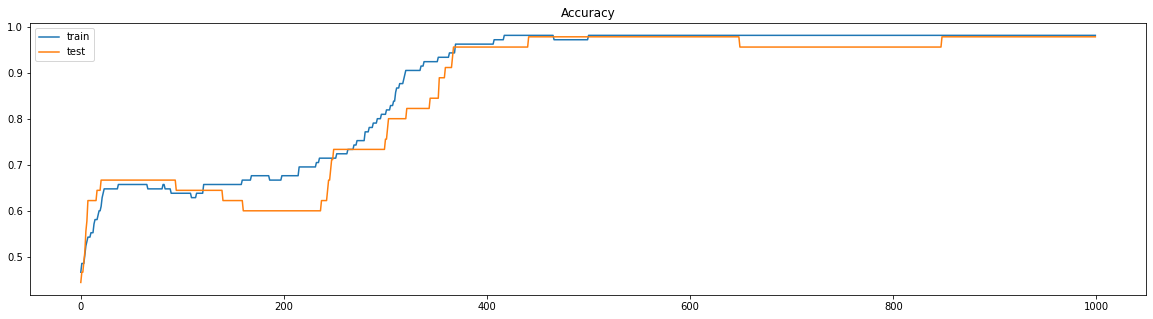

In [9]:
plt.figure(figsize=(20,5))
plt.title('Accuracy')
plt.plot(nnet.train_accuracy_list, label='train')
plt.plot(nnet.test_accuracy_list, label='test')
plt.legend();

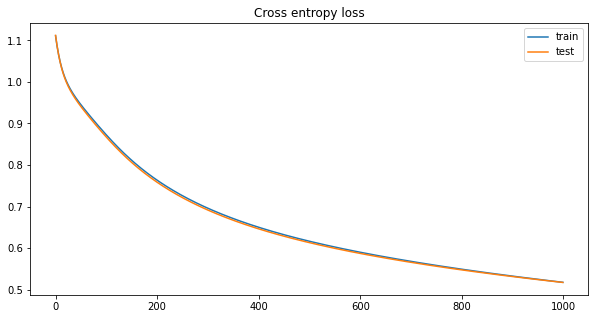

In [10]:
plt.figure(figsize=(10,5))
plt.title('Cross entropy loss')
plt.plot(nnet.loss_train_list, label='train')
plt.plot(nnet.loss_test_list, label='test')
plt.legend();

# Binary classification

In [0]:
x, y = make_classification(n_samples=1000, 
                           n_features=10, 
                           n_informative=6,
                           n_redundant=2,
                           n_clusters_per_class=1,
                           n_classes=2,
                           random_state=1)

In [12]:
n_classes = np.unique(y).shape[0]
y_cat = pd.get_dummies(y).values
x_train, x_test, y_train, y_test = train_test_split(x, y_cat, test_size=0.3, random_state=42, stratify=y)
print('Train shape: ', x_train.shape, '\nTest shape:', x_test.shape)

Train shape:  (700, 10) 
Test shape: (300, 10)


In [0]:
nnet = NeuralNetworkClassifier([Layer(10, input_shape=x.shape[1]),
                                Layer(n_classes)],
                               random_state=1)

In [14]:
nnet.fit(x_train, y_train, 
         x_test, y_test, 
         lr=0.001, 
         n_epochs=3000, 
         batch_size=10)

Epoch 0, Loss Train/Test: 1.0901 / 1.0865, Accuracy score Train/Test: 0.4571 / 0.4567
Epoch 100, Loss Train/Test: 0.2517 / 0.2312, Accuracy score Train/Test: 0.9429 / 0.9567
Epoch 200, Loss Train/Test: 0.1800 / 0.1627, Accuracy score Train/Test: 0.9571 / 0.9633
Epoch 300, Loss Train/Test: 0.1546 / 0.1399, Accuracy score Train/Test: 0.9586 / 0.9633
Epoch 400, Loss Train/Test: 0.1416 / 0.1289, Accuracy score Train/Test: 0.9614 / 0.9600
Epoch 500, Loss Train/Test: 0.1338 / 0.1223, Accuracy score Train/Test: 0.9629 / 0.9600
Epoch 600, Loss Train/Test: 0.1284 / 0.1177, Accuracy score Train/Test: 0.9643 / 0.9600
Epoch 700, Loss Train/Test: 0.1243 / 0.1141, Accuracy score Train/Test: 0.9671 / 0.9600
Epoch 800, Loss Train/Test: 0.1211 / 0.1111, Accuracy score Train/Test: 0.9671 / 0.9600
Epoch 900, Loss Train/Test: 0.1183 / 0.1085, Accuracy score Train/Test: 0.9671 / 0.9600
Epoch 1000, Loss Train/Test: 0.1159 / 0.1062, Accuracy score Train/Test: 0.9657 / 0.9600
Epoch 1100, Loss Train/Test: 0.11

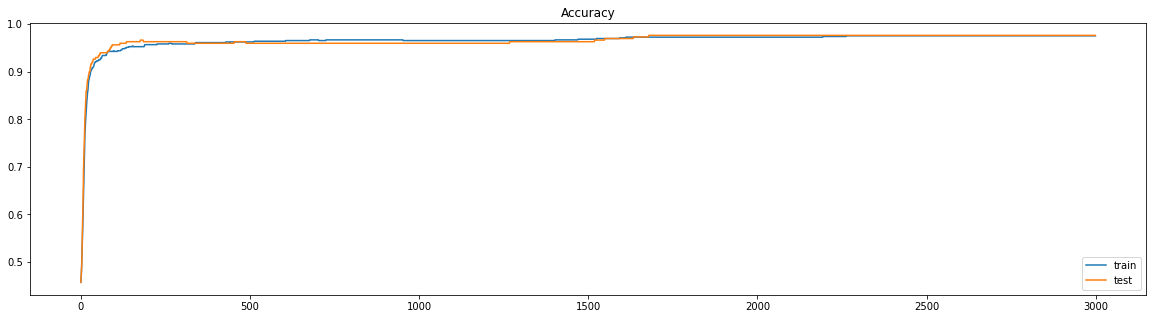

In [15]:
plt.figure(figsize=(20,5))
plt.title('Accuracy')
plt.plot(nnet.train_accuracy_list, label='train')
plt.plot(nnet.test_accuracy_list, label='test')
plt.legend();

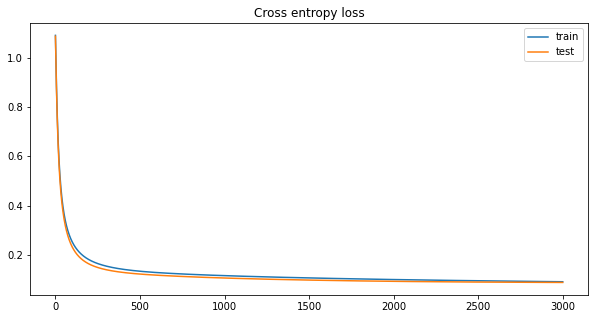

In [16]:
plt.figure(figsize=(10,5))
plt.title('Cross entropy loss')
plt.plot(nnet.loss_train_list, label='train')
plt.plot(nnet.loss_test_list, label='test')
plt.legend();

# TMDB

In [17]:
!pip install cpi

In [0]:
import warnings
warnings.simplefilter('ignore')

import json
import cpi

from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [0]:
data = pd.read_csv('drive/My Drive/tmdb_5000_movies.csv')

In [20]:
#delete unstructured data
data = data.drop(['tagline', 'overview', 'homepage', 'original_title', 'id', 'status'], axis=1)
print(data.shape)
data = data[(data['runtime']!=0.0) &
            (data['revenue']!=0.0)]

(4803, 14)


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3375 entries, 0 to 4798
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                3375 non-null   int64  
 1   genres                3375 non-null   object 
 2   keywords              3375 non-null   object 
 3   original_language     3375 non-null   object 
 4   popularity            3375 non-null   float64
 5   production_companies  3375 non-null   object 
 6   production_countries  3375 non-null   object 
 7   release_date          3375 non-null   object 
 8   revenue               3375 non-null   int64  
 9   runtime               3375 non-null   float64
 10  spoken_languages      3375 non-null   object 
 11  title                 3375 non-null   object 
 12  vote_average          3375 non-null   float64
 13  vote_count            3375 non-null   int64  
dtypes: float64(3), int64(3), object(8)
memory usage: 395.5+ KB


## Data preparation

In [0]:
data['release_date'] = pd.to_datetime(data['release_date'])
data.sort_values('release_date', inplace=True)
data['release_month'] = data['release_date'].dt.month
data['release_dayofweek'] = data['release_date'].dt.dayofweek
data['release_year'] = data['release_date'].dt.year

data['decade'] = data['release_year'].apply(lambda x: str(x)[:-1])

def fix_inflation(row):
    row['revenue_fix'] = cpi.inflate(row['revenue'], row['release_date'])
    row['budget_fix'] = cpi.inflate(row['budget'], row['release_date'])

    return row

data = data.apply(fix_inflation,axis=1)

def get_dict_value(row, feature, target_key='name'):
    list_ = json.loads(row[feature])
    row[feature+'_1'] = list_[0][target_key] if list_ else None

    return row
    
data = data.apply(get_dict_value, args=('genres',), axis=1)
data = data.apply(get_dict_value, args=('production_companies',), axis=1)
data = data.apply(get_dict_value, args=('production_countries',), axis=1)

clearned_data = data.copy()
clearned_data.drop(['genres', 'keywords', 'production_companies', 
                    'production_countries', 'spoken_languages', 
                    'release_date', 'popularity', 'vote_count', 
                    'revenue', 'budget', 'title', 'vote_average'], axis=1, inplace=True
                   )

clearned_data['genres_1'].fillna('na', inplace=True)
clearned_data['production_companies_1'].fillna('na', inplace=True)
clearned_data['production_countries_1'].fillna('na', inplace=True)

for feature, threshold in zip (['genres_1', 'production_companies_1', 'production_countries_1', 'original_language'], [20, 6, 2000, 3000]):
    count_data = clearned_data[feature].value_counts()
    values_for_replacing = count_data[count_data < threshold].index
    clearned_data[feature] = clearned_data[feature].apply(lambda x: 'Others' if x in values_for_replacing else x)

numerical_col = ['budget_fix',	'runtime']
for feature in numerical_col:
    clearned_data[feature+'_log'] = np.log(clearned_data[feature]+1)

## New target variable

In [23]:
qu1 = clearned_data['revenue_fix'].quantile(0.33)
qu2 = clearned_data['revenue_fix'].quantile(0.66)
print(qu1, qu2)
def get_classes(row):
    class_ = None
    if row['revenue_fix'] < qu1:
        row['revenue_class'] = 0
    elif qu1 <= row['revenue_fix'] < qu2:
        row['revenue_class'] = 1
    elif row['revenue_fix'] >= qu2:
        row['revenue_class'] = 2
    return row

clearned_data = clearned_data.apply(get_classes, axis=1)
clearned_data['revenue_class'].value_counts(normalize=True)

39146044.70122607 141064203.59021637


2    0.340148
0    0.330074
1    0.329778
Name: revenue_class, dtype: float64

## Neural network

In [0]:
X_cat_oh = pd.get_dummies(clearned_data[['genres_1', 
                                        'production_companies_1', 
                                        'production_countries_1', 
                                         'release_dayofweek',
                                         'release_month',
                                         'decade',
                                         ]])
X_numeric = clearned_data[['budget_fix_log', 'runtime_log']]

y = clearned_data['revenue_class']
n_classes = np.unique(y).shape[0]
y_cat = pd.get_dummies(y).values

shuffle=False because I want to train models to predict revenue_class for modern movies

In [29]:
r_state = 42
X_cat_oh_train, X_cat_oh_test, y_train, y_test = train_test_split(X_cat_oh, y_cat, 
                                                                  test_size=0.2, 
                                                                  shuffle=False, 
                                                                  #stratify=y,
                                                                  random_state=r_state,
                                                                  )

X_numeric_train, X_numeric_test = train_test_split(X_numeric,
                                                    test_size=0.2, 
                                                    shuffle=False,
                                                    #stratify=y,
                                                    random_state=r_state,
                                                   )

scaler = StandardScaler()
X_numeric_train_scaled = scaler.fit_transform(X_numeric_train)
X_numeric_test_scaled = scaler.transform(X_numeric_test)

X_train = np.hstack([X_numeric_train_scaled, X_cat_oh_train, ])
X_test = np.hstack([X_numeric_test_scaled, X_cat_oh_test, ])

print('\nTrain data', X_train.shape, '\nTest data', X_test.shape)


Train data (2700, 108) 
Test data (675, 108)


It's time to take advantage of my perfect neural network

### Without dropout

In [0]:
nnet = NeuralNetworkClassifier([Layer(60, input_shape=X_train.shape[1]),
                                Layer(20),
                                Layer(n_classes, f_activation='softmax')],
                               random_state=1)

In [31]:
%%time
nnet.fit(X_train, y_train, 
         X_test, y_test, 
         lr=0.01, 
         n_epochs=1500, 
         batch_size=10)

Epoch 0, Loss Train/Test: 1.1397 / 1.1333, Accuracy score Train/Test: 0.3767 / 0.3852
Epoch 100, Loss Train/Test: 0.8942 / 0.8066, Accuracy score Train/Test: 0.5681 / 0.6222
Epoch 200, Loss Train/Test: 0.8503 / 0.7941, Accuracy score Train/Test: 0.6037 / 0.6296
Epoch 300, Loss Train/Test: 0.8102 / 0.7909, Accuracy score Train/Test: 0.6352 / 0.6311
Epoch 400, Loss Train/Test: 0.7723 / 0.7961, Accuracy score Train/Test: 0.6504 / 0.6400
Epoch 500, Loss Train/Test: 0.7422 / 0.8070, Accuracy score Train/Test: 0.6600 / 0.6281
Epoch 600, Loss Train/Test: 0.7158 / 0.8227, Accuracy score Train/Test: 0.6693 / 0.6178
Epoch 700, Loss Train/Test: 0.6894 / 0.8430, Accuracy score Train/Test: 0.6856 / 0.6074
Epoch 800, Loss Train/Test: 0.6627 / 0.8690, Accuracy score Train/Test: 0.7022 / 0.6015
Epoch 900, Loss Train/Test: 0.6358 / 0.9013, Accuracy score Train/Test: 0.7185 / 0.6030
Epoch 1000, Loss Train/Test: 0.6097 / 0.9376, Accuracy score Train/Test: 0.7359 / 0.5970
Epoch 1100, Loss Train/Test: 0.58

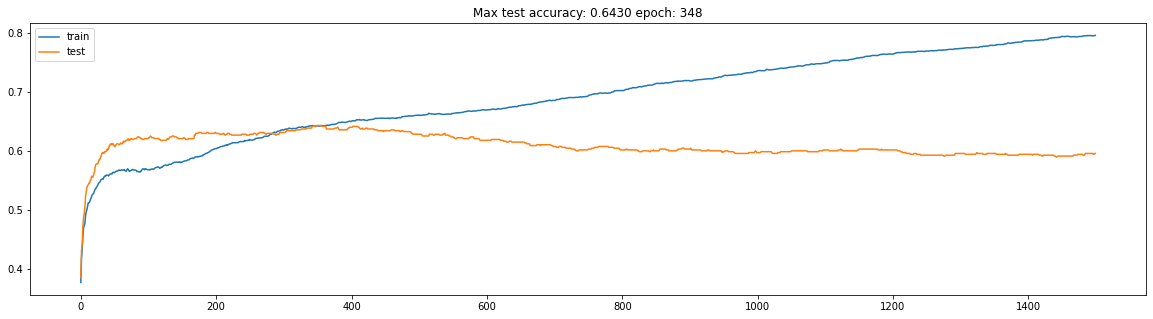

In [32]:
plt.figure(figsize=(20,5))
plt.title('Max test accuracy: %.4f epoch: %s' % (np.max((nnet.test_accuracy_list)), np.argmax(nnet.test_accuracy_list)))
plt.plot(nnet.train_accuracy_list, label='train')
plt.plot(nnet.test_accuracy_list, label='test')
plt.legend();

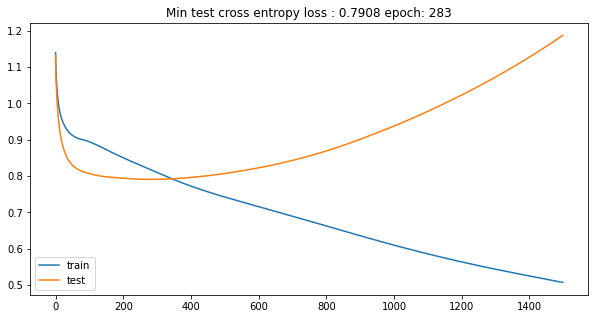

In [33]:

plt.figure(figsize=(10,5))
plt.title('Min test cross entropy loss : %.4f epoch: %s' % (np.min((nnet.loss_test_list)), np.argmin(nnet.loss_test_list)))
plt.plot(nnet.loss_train_list, label='train')
plt.plot(nnet.loss_test_list, label='test')
plt.legend();

### Dropout

In [0]:
nnet = NeuralNetworkClassifier([Layer(60, input_shape=X_train.shape[1]),
                                Layer(20),
                                Layer(n_classes, f_activation='softmax')],
                               random_state=1)

In [35]:
%%time
nnet.fit(X_train, y_train, 
         X_test, y_test, 
         lr=0.01, 
         n_epochs=2500, 
         batch_size=10,
         dropout=0.1)

Epoch 0, Loss Train/Test: 1.1850 / 1.1704, Accuracy score Train/Test: 0.3419 / 0.3481
Epoch 100, Loss Train/Test: 0.9221 / 0.8336, Accuracy score Train/Test: 0.5581 / 0.6089
Epoch 200, Loss Train/Test: 0.8916 / 0.7944, Accuracy score Train/Test: 0.5730 / 0.6193
Epoch 300, Loss Train/Test: 0.8814 / 0.7852, Accuracy score Train/Test: 0.5722 / 0.6252
Epoch 400, Loss Train/Test: 0.8609 / 0.7783, Accuracy score Train/Test: 0.5941 / 0.6296
Epoch 500, Loss Train/Test: 0.8517 / 0.7724, Accuracy score Train/Test: 0.5956 / 0.6385
Epoch 600, Loss Train/Test: 0.8395 / 0.7736, Accuracy score Train/Test: 0.6041 / 0.6370
Epoch 700, Loss Train/Test: 0.8379 / 0.7770, Accuracy score Train/Test: 0.6019 / 0.6504
Epoch 800, Loss Train/Test: 0.8269 / 0.7744, Accuracy score Train/Test: 0.6122 / 0.6415
Epoch 900, Loss Train/Test: 0.8247 / 0.7821, Accuracy score Train/Test: 0.6133 / 0.6459
Epoch 1000, Loss Train/Test: 0.8166 / 0.7777, Accuracy score Train/Test: 0.6226 / 0.6370
Epoch 1100, Loss Train/Test: 0.81

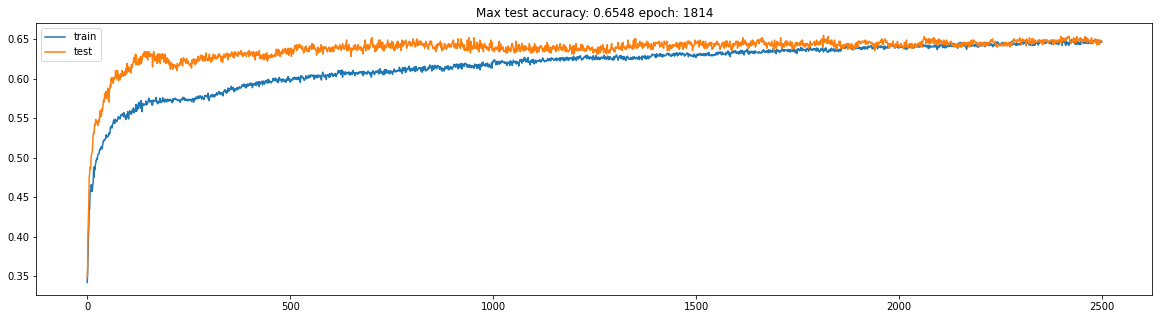

In [36]:
plt.figure(figsize=(20,5))
plt.title('Max test accuracy: %.4f epoch: %s' % (np.max((nnet.test_accuracy_list)), np.argmax(nnet.test_accuracy_list)))
plt.plot(nnet.train_accuracy_list, label='train')
plt.plot(nnet.test_accuracy_list, label='test')
plt.legend();

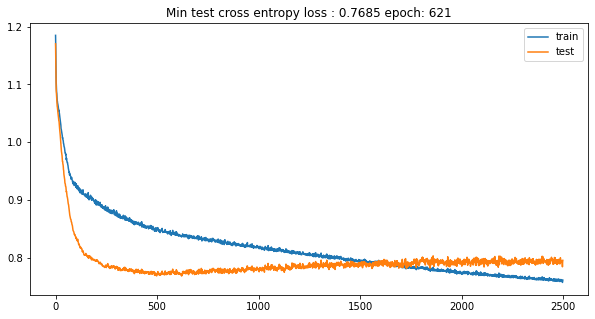

In [37]:
plt.figure(figsize=(10,5))
plt.title('Min test cross entropy loss : %.4f epoch: %s' % (np.min((nnet.loss_test_list)), np.argmin(nnet.loss_test_list)))
plt.plot(nnet.loss_train_list, label='train')
plt.plot(nnet.loss_test_list, label='test')
plt.legend();

In [39]:
pred = nnet.predict_classes(X_test)
print(classification_report(nnet.get_classes_by_probas(y_test), pred))

              precision    recall  f1-score   support

           0       0.62      0.82      0.71       220
           1       0.52      0.35      0.42       224
           2       0.76      0.77      0.76       231

    accuracy                           0.65       675
   macro avg       0.63      0.65      0.63       675
weighted avg       0.63      0.65      0.63       675



# References which helped me

*  [Softmax, softmax derivative](http://www.adeveloperdiary.com/data-science/deep-learning/neural-network-with-softmax-in-python/)
*  [Structure of class NeuralNetwork](https://keras.io/getting-started/sequential-model-guide/)
*  [Backprop](https://habr.com/ru/post/313216/)
*  [Sigmoid derivative](https://github.com/SkalskiP/ILearnDeepLearning.py/blob/master/01_mysteries_of_neural_networks/03_numpy_neural_net/Numpy%20deep%20neural%20network.ipynb)
*  [Dropout](https://wiseodd.github.io/techblog/2016/06/25/dropout/)
